In [1]:
# using tensorflow_gpuenv

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import requests, zipfile, io
import scipy
import time

hello=tf.constant('Hello,TensorFlow!')

sess=tf.Session()

print(sess.run(hello))


b'Hello,TensorFlow!'


## Getting the vocabulary

We determine our vocabulary by looking at the Google "English 1 Million" unigram data. Since this comes from the same source as the ngram data we will be studying, this provides consistnecy. Additionally, since this data is drawn from sources spanning the time period we're studing, it can be expected to be more representative of english over this broader time period, while other sources may reflect a more modern english.

### Tokenizing

In order to simplify the text we're looking at, all text is converted to lowercase and all "words" composed entirely of non-alphabetic symbols are replaced with a "#NUM" tag. If a non-alphabetic symbol appears partway through a word (e.g. an apostrophe or hyphen), only the first part of the word will be recorded.

In [ ]:
all_words = {}

def clean_word(string):
    wordlist = re.findall(r"[a-z]+", string.lower())
    word = ""
    if len(wordlist) == 0:
        word = "#NUM"
    else:
        word = wordlist[0]
    return word
    

def get_word_counts(data, all_words):
    worddata = data.groupby("word")["total"].sum()
    for index, value in worddata.iteritems():
        currentword = str(index)
        word = clean_word(currentword)
        if word in all_words:
            all_words[word] += value
        else:
            all_words[word] = value

In [ ]:
for i in range(10):
    filename = "googlebooks-eng-1M-1gram-20090715-" + str(i) + ".csv"
    data = pd.read_csv(filename, 
                       sep = '\t', 
                       header = None, 
                       names = ["word","year","total","pages","books"],
                       quotechar=None, 
                       quoting=3,
                       encoding = "ISO-8859-1")
    print(data.head())
    get_word_counts(data, all_words)

  word  year  total  pages  books
0    #  1574      1      1      1
1    #  1584      6      6      1
2    #  1614      1      1      1
3    #  1631    115    100      1
4    #  1632      3      3      1
  word  year  total  pages  books
0    $  1520      1      1      1
1    $  1575     12     12      2
2    $  1576      1      1      1
3    $  1581      1      1      1
4    $  1584     41     38      1
     word  year  total  pages  books
0  $0.007  1905      1      1      1
1  $0.007  1910      2      2      2
2  $0.007  1911      3      3      3
3  $0.007  1912      6      6      6
4  $0.007  1913      4      4      4


In [ ]:
keys = random.sample(list(all_words), 1000)
print(keys[:10])

In [ ]:
len(all_words)

In [ ]:
counts = []
for word in keys:
    count = all_words[word]
    counts.append(count)
    if(count>1e4):
        print(word)
        print(count)
plt.hist(counts)

In [ ]:
top_words = {}
word_to_index = {}
index_to_word = {}
cutoff = 1e5
top_word_count = 0
extra_word_count = 0
i = 0
words = []
counts = []
for word, count in all_words.items():
    if(count>cutoff):
        top_words[word] = count
        top_word_count += count
        words.append(word)
        counts.append(count)
        #word_to_index[word] = i
        #index_to_word[i] = word
        i += 1
    else:
        extra_word_count += count

indices = np.argsort(-1*np.array(counts))
for order, index in enumerate(indices):
    word_to_index[words[index]] = order
    index_to_word[order] = words[index]
        
print(str(len(top_words)) + " words")
print("appearing " + str(top_word_count) + " times")
print("others appear " + str(extra_word_count) + " times")

In [ ]:
print(word_to_index["the"])
print(word_to_index["man"])
print(word_to_index["calculate"])

In [ ]:
print(top_word_count/(extra_word_count + top_word_count))

In [ ]:
pd.DataFrame.from_dict(top_words, orient='index').to_csv("vocabCounts.csv")
pd.DataFrame.from_dict(index_to_word, orient='index').to_csv("vocabIndexed.csv")

In [11]:
# if re-running: 
def load_vocab(top_word_dict, word_to_index_dict, index_to_word_dict):
    top_word_df = pd.read_csv("vocabCounts.csv", names=["word","count"], header=0)
    total_count = 0
    for index, row in top_word_df.iterrows():
        top_word_dict[row["word"]] = row["count"]
        total_count += row["count"]
        word_to_index_dict[row["word"]] = index
        index_to_word_dict[index]=row["word"]
    return total_count
    
#top_words = {}
#word_to_index = {}
#index_to_word = {}

#total_count = load_vocab(top_words, word_to_index, index_to_word)
#print(total_count)
    

In [ ]:
maxyear = 2008
minyear = 1800

decades = list(range(minyear - minyear%10, maxyear, 10))
decades

According to Mikolov, the best results from skipgram came from training with a loss function of negative sampling with k=15. This means using "tf.nn.sampled_softmax_loss" with num_sampled = 15, num_classes = vocab size, and num_true=1.
source: https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss

From hw4:

embed_shape = [self.V, self.H]

self.W_in_ = tf.get_variable("W_in", embed_shape, initializer=tf.initializers.random_uniform(minval=-1.0,maxval=1.0))

x_in_ = tf.nn.embedding_lookup(self.W_in_, self.input_w_)

In [ ]:
vocab_size = len(top_words) + 1
embed_dim = 300
neg_samples = 5
learning_rate_ = .001

In [14]:
W_e_ = {}
W_nce_ = {}
b_nce_ = {}

print("Data from " + str(minyear) + " to " + str(maxyear))
for decade in decades:
    # initialize embeddings
    with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE): 
        W_e_[decade] = tf.get_variable("W_e_" + str(decade), 
                       [vocab_size, embed_dim], 
                       initializer = tf.initializers.random_uniform(minval=-1.0,
                                                                    maxval=1.0, 
                                                                    seed = 47))
        W_nce_[decade] = tf.get_variable("W_nce_" + str(decade), 
                       [vocab_size, embed_dim], 
                       initializer = tf.initializers.random_uniform(minval=-1.0,
                                                                    maxval=1.0, 
                                                                    seed = 47))
        b_nce_[decade] = tf.get_variable("b_nce_" + str(decade), 
                       [vocab_size])

Data from 1800 to 2008


follow the directions in https://www.tensorflow.org/tutorials/representation/word2vec to get skipgram model running

In [ ]:
v_center_ = {}
train_loss_ = {}
train_step_ = {}

batch_size = 32

center_word_ids_ = tf.placeholder(tf.int32, [batch_size])
context_word_ids_ = tf.placeholder(tf.int32, [batch_size,1])

for decade in decades:

    v_center_[decade] = tf.nn.embedding_lookup(W_e_[decade], center_word_ids_)
    
    
    train_loss_[decade] = tf.reduce_mean(
        tf.nn.nce_loss(weights=W_e_[decade],
                 biases=b_nce_[decade],
                 labels=context_word_ids_,
                 inputs=v_center_[decade],
                 num_sampled=neg_samples,
                 num_classes=vocab_size))
    
    train_step_[decade] = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(train_loss_[decade])
    
init=tf.global_variables_initializer()

In [16]:
def words_to_indices(wordlist, wordindices):
    indexlist = [vocab_size - 1,vocab_size -1,vocab_size -1,vocab_size -1,vocab_size -1]
    for i in range(len(wordlist)):
        currentword = wordlist[i]
        cleanword = clean_word(currentword)
        if(cleanword in wordindices):
            indexlist[i] = wordindices[cleanword]
    #indextuple = tuple(indexlist)
    return indexlist

def ngram_to_df(fileurl):
    #response = requests.get(fileurl)
    #zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    #zip_file.extractall("temp")
    
    decade_data = {}
    for decade in decades:
        # initialize dictionary
        decade_data[decade] = {}
        
    data = 0
    start = time.time()
    while True:
        try:
            data = pd.read_csv(fileurl, 
                       sep = '\t', 
                       header = None, 
                       names = ["words","year","total","pages","books"],
                       quotechar=None, 
                       quoting=3,
                       encoding = "ISO-8859-1")
        except:
            print("trying downloading "+ fileurl + " again... ")
        else:
            break
    end = time.time()
    print(str(end-start) + " elapsed while downloading and reading")
    for decade in decades:
        decade_data[decade] = data.loc[(data['year'] >= decade) & (data['year'] < decade+10)]
    
    return decade_data

In [17]:
sess.run(init)

run skipgram for each decade

In [19]:
max_iter = 201

for filenum in range(800):
    url = "http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-" + str(filenum) +".csv.zip"
    print("downloaded " + url)
    #decade_dicts = ngram_to_decade_dict(url, word_to_index, decades)
    decade_data =  ngram_to_df(url)
    for decade in decades:
        num_ngrams = len(decade_data[decade])
        totalcost = 0
        itercount = 0
        if(num_ngrams >= batch_size):
            print("Training decade " + str(decade))
            max_decade_iter = min(max_iter, int(num_ngrams/(batch_size)))
            for iteration in range(max_decade_iter):
                traindf = decade_data[decade].sample(n=batch_size, weights='total')
                trainarray = np.zeros([batch_size,5])
                i=0
                for index, row in traindf.iterrows():
                    trainarray[i] = words_to_indices(str(row["words"]).lower().split(" "), word_to_index)
                    i+=1
                    
                for i in range(5):
                    for j in range(5):
                        if(i != j):
                            feed_dict = {
                                context_word_ids_ : np.array([x[i] for x in trainarray]).reshape((batch_size,1)),
                                center_word_ids_ : [x[j] for x in trainarray],
                            }

                            ops = [train_loss_[decade], train_step_[decade]]        

                            cost, _ = sess.run(ops, feed_dict)
                            totalcost+= cost
                            itercount +=1
                
                if(iteration % 100 == 0):
                    print(str(totalcost*1.0/itercount))     
                    totalcost = 0
                    itercount = 0

downloaded http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-0.csv.zip
13.223997831344604 elapsed while downloading and reading
Training decade 1800
43.50765295028687
33.38019802474975
25.39436999607086
Training decade 1810
39.50950698852539
33.07014695882797
26.10335299563408
Training decade 1820
39.23233604431152
33.0833132557869
25.647154844999314
Training decade 1830
37.4691463470459
32.81011059713364
25.64497305083275
Training decade 1840
43.60022945404053
32.93515547275543
25.682531182050706
Training decade 1850
40.326936912536624
32.831509882450106
26.063046204090117
Training decade 1860
37.87169179916382
33.16559965848923
25.441925102829934
Training decade 1870
41.86225357055664
33.18309468984604
25.787134884119034
Training decade 1880
39.80407199859619
33.30011394619942
25.88941952085495
Training decade 1890
41.8862738609314
33.03364254760742
25.635793842554094
Training decade 1900
41.81781930923462
33.44849569559097
26.0292365834713
Training d

16.00951726436615
15.193459299564362
14.71101414591074
Training decade 1920
14.548074412345887
15.273518750667572
14.610462765216827
Training decade 1930
15.7688227891922
15.247226375699043
14.491750212430954
Training decade 1940
16.513114261627198
15.302461016416549
14.400700686573982
Training decade 1950
16.688998174667358
15.01257856118679
14.471481067061424
Training decade 1960
18.06006157398224
15.073634300231934
14.35211719608307
Training decade 1970
17.917775058746336
14.705652047991753
14.099982310175896
Training decade 1980
16.15220091342926
14.813071798324584
14.287405767917633
Training decade 1990
12.749226939678191
14.626022825360298
14.127144466996192
Training decade 2000
15.78187255859375
14.791845195174217
14.138945751309395
downloaded http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-5.csv.zip
15.591100454330444 elapsed while downloading and reading
Training decade 1800
13.905279648303985
13.518103141307831
12.995856720209122
Training de

14.207036662101746
11.074146910130978
10.57863881266117
Training decade 1810
8.54562692642212
11.082791092157365
10.668771999895572
Training decade 1820
13.950751256942748
11.202903861522675
10.955703623950482
Training decade 1830
13.76532918214798
11.194225274860859
10.661979960799217
Training decade 1840
13.724734556674957
11.26367696505785
10.78394246160984
Training decade 1850
10.526212978363038
11.276152629673481
10.872634472191335
Training decade 1860
13.339467489719391
11.490145991444587
11.02539398151636
Training decade 1870
11.51904512643814
10.840355740249157
10.872120037734508
Training decade 1880
12.522896146774292
11.32881991994381
10.911676108658314
Training decade 1890
10.087084650993347
11.234452547311783
11.109166144549846
Training decade 1900
9.985162854194641
11.322097551584244
10.913419123649597
Training decade 1910
10.852342295646668
11.209804035067558
11.042199073672295
Training decade 1920
9.8148144364357
11.06531648504734
10.66391074949503
Training decade 1930
1

9.577819550037384
9.668481001615524
9.36367912632227
Training decade 1960
9.047578930854797
9.562096575915813
9.296585916459561
Training decade 1970
8.331957864761353
9.32832584297657
9.282071839988232
Training decade 1980
7.501572585105896
9.20217474156618
8.98353134983778
Training decade 1990
9.27609726190567
9.32017755126953
9.042480814814567
Training decade 2000
11.97176969051361
9.182382535219192
9.175356850862503
downloaded http://storage.googleapis.com/books/ngrams/books/googlebooks-eng-1M-5gram-20090715-14.csv.zip
19.77558708190918 elapsed while downloading and reading
Training decade 1800
6.214820027351379
9.070077180743217
8.988579033911229
Training decade 1810
7.51199301481247
9.057682437419892
8.995207705259324
Training decade 1820
9.754593253135681
9.483692289113998
9.447554498016835
Training decade 1830
6.93818279504776
9.33713596099615
8.998624807834625
Training decade 1840
13.110500860214234
9.52123397409916
9.385082269728183
Training decade 1850
8.479729771614075
9.725

KeyboardInterrupt: 

In [20]:
last_decade = decades[-1]
most_recent_embed = sess.run(W_e_[last_decade])
aligned_embeddings = {}
embeddings = {}


# align past decades to current english using orthogonal procrustes
for i, decade in enumerate(decades):
    decade_embed =  sess.run(W_e_[decade])
    embeddings[decade] = decade_embed
    conversion = scipy.linalg.orthogonal_procrustes(decade_embed, most_recent_embed)
    print(str(decade) + " aligns with svd sum "+str(conversion[1]))
    aligned = np.dot(decade_embed, conversion[0])
    aligned_embeddings[decade] = aligned
    np.savetxt("embeddings_" + str(decade) + ".csv", aligned)

1800 aligns with svd sum 3038778.8
1810 aligns with svd sum 3039393.0
1820 aligns with svd sum 3038877.5
1830 aligns with svd sum 3040428.2
1840 aligns with svd sum 3040296.0
1850 aligns with svd sum 3041538.0
1860 aligns with svd sum 3042154.8
1870 aligns with svd sum 3042996.0
1880 aligns with svd sum 3042724.8
1890 aligns with svd sum 3043756.8
1900 aligns with svd sum 3045412.5
1910 aligns with svd sum 3046124.0
1920 aligns with svd sum 3047367.2
1930 aligns with svd sum 3048050.5
1940 aligns with svd sum 3048823.5
1950 aligns with svd sum 3048880.5
1960 aligns with svd sum 3048868.8
1970 aligns with svd sum 3049678.5
1980 aligns with svd sum 3050423.2
1990 aligns with svd sum 3050949.8
2000 aligns with svd sum 3076779.5


In [21]:
def embedding_lookup(word,embeddingmx):
    wordindex = len(word_to_index)
    if(word in word_to_index):
        wordindex = word_to_index[word]
    embedding = embeddingmx[wordindex]
    return embedding
    
def cos_sim(x,y):
    return np.dot(x,y)/np.sqrt(np.dot(x,x)*np.dot(y,y))

def cos_sim_words(x, y, embeddingmx):
    x_embed = embedding_lookup(x,embeddingmx)
    y_embed = embedding_lookup(y,embeddingmx)
    return cos_sim(x_embed, y_embed)

def cos_sim_time(word1, word2, decades, embedding_dict):
    sims = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        word1embed = embedding_lookup(word1, embedding_dict[decade])
        word2embed = embedding_lookup(word2, embedding_dict[decade])
        cos = cos_sim(word1embed, word2embed)
        sims[i] = cos
    return sims

In [22]:
# visualize on "he-she" projection vs time   
    

def eval_analogy(a, b, c, d, embedding):
    embeda = embedding_lookup(a, embedding)
    embedb = embedding_lookup(b, embedding)
    embedc = embedding_lookup(c, embedding)
    embedd = embedding_lookup(d, embedding)
    target = embedc-embeda+embedb
    return cos_sim(target, embedd)
        
def eval_analogy_time(a, b, c, d, decades, embedding_dict):
    cos_sim = np.zeros(len(decades))
    for i, decade in enumerate(decades):
        cos = eval_analogy(a,b,c,d, embedding_dict[decade])
        cos_sim[i] = cos
    return cos_sim


graph results

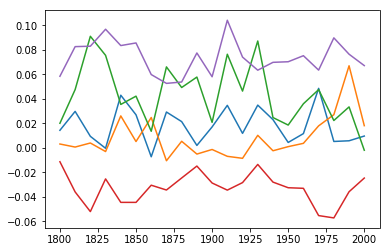

In [31]:
a = "woman"
b = "man"

bolubasi_biased = [("sewing", "carpentry"),
                   ("housewife", "shopkeeper"),
                   ("nurse", "surgeon"),
                   ("blonde", "burly"),
                   ("feminism","conservatism")]

bolubasi_appropriate = [("girls","boys"),
                        ("sister","brother"),
                        ("motherhood","fatherhood"),
                        ("heroine","hero"),
                        ("queen","king")]
for pair in bolubasi_biased:
    plt.plot(decades,eval_analogy_time(a,b,pair[0],pair[1], decades, embeddings))


In [30]:
def complete_analogy(a,b,c, embeddings):
    embeda = embedding_lookup(a, embeddings)
    embedb = embedding_lookup(b, embeddings)
    embedc = embedding_lookup(c, embeddings)
    target = embedc-embeda+embedb
    maxsim = 0
    maxword = ""
    for word, index in word_to_index.items():
        wordembed = embedding_lookup(word, embeddings)
        cos = cos_sim(wordembed, target)
        if(cos > maxsim):
            maxword = word
            maxsim = cos
    return maxword
        
decade = 1900
print(complete_analogy("man","woman","king", embeddings[decade]))
print(complete_analogy("man","woman","uncle", embeddings[decade]))
print(complete_analogy("man","woman","brother", embeddings[decade]))
print(complete_analogy("man","woman","boy", embeddings[decade]))
print(complete_analogy("he","she","man", embeddings[decade]))       

woman
uncle
brother
boy
man


In [35]:
def check_analogy(a,b,c,d,embeddings):
    answer = complete_analogy(a,b,c,embeddings)
    print(a + ' ' + b + ' ' + c  + ' ...' + answer + " (correct : " + d +")")
    if(answer == d):
        return 1
    else:
        return 0


with open('analogy-checks-from-tf.txt') as f:
    lines = f.readlines()
    
lines = [x.strip().split(" ") for x in lines] 
lines_filtered = list(filter(lambda x: len(x) == 4, lines[-1000:]))
total_analogies = len(lines_filtered)
accuracies = np.zeros(len(decades))
for i, decade in enumerate(decades):
    correct = [check_analogy(x[0],x[1],x[2],x[3],embeddings[decade]) for x in lines_filtered]
    accuracy = sum(correct) * 1.0 / total_analogies
    accuracies[i] = accuracy
    print(str(decade) + " with accuracy: " + str(accuracy))
    
plt.plot(decades, accuracies)
plt.show()

rat rats dollar ...rats (correct : dollars)
rat rats donkey ...donkey (correct : donkeys)
rat rats dream ...dream (correct : dreams)
rat rats eagle ...eagle (correct : eagles)
rat rats elephant ...rats (correct : elephants)
rat rats eye ...rats (correct : eyes)
rat rats finger ...rats (correct : fingers)
rat rats goat ...rats (correct : goats)
rat rats hand ...hand (correct : hands)
rat rats horse ...rats (correct : horses)
rat rats lion ...rats (correct : lions)
rat rats machine ...machine (correct : machines)
rat rats mango ...mango (correct : mangoes)
rat rats man ...man (correct : men)
rat rats melon ...rats (correct : melons)
rat rats monkey ...monkey (correct : monkeys)
rat rats mouse ...rats (correct : mice)
rat rats onion ...rats (correct : onions)
rat rats pear ...rats (correct : pears)
rat rats pig ...pig (correct : pigs)
rat rats pineapple ...rats (correct : pineapples)
road roads snake ...snake (correct : snakes)
road roads woman ...roads (correct : women)
road roads banana

describe describes scream ...scream (correct : screams)
describe describes search ...search (correct : searches)
describe describes see ...see (correct : sees)
describe describes shuffle ...that (correct : shuffles)
describe describes sing ...sing (correct : sings)
describe describes sit ...describes (correct : sits)
describe describes slow ...slow (correct : slows)
describe describes speak ...speak (correct : speaks)
describe describes swim ...swim (correct : swims)
describe describes talk ...talk (correct : talks)
describe describes think ...think (correct : thinks)
describe describes vanish ...vanish (correct : vanishes)
describe describes walk ...walk (correct : walks)
describe describes work ...describes (correct : works)
describe describes write ...describes (correct : writes)
describe describes decrease ...decrease (correct : decreases)
eat eats enhance ...enhance (correct : enhances)
eat eats estimate ...estimate (correct : estimates)
eat eats find ...find (correct : finds)
eat

generate generates find ...find (correct : finds)
go goes implement ...implement (correct : implements)
go goes increase ...goes (correct : increases)
go goes listen ...listen (correct : listens)
go goes play ...goes (correct : plays)
go goes predict ...predict (correct : predicts)
go goes provide ...provide (correct : provides)
go goes say ...goes (correct : says)
go goes scream ...scream (correct : screams)
go goes search ...goes (correct : searches)
go goes see ...goes (correct : sees)
go goes shuffle ...goes (correct : shuffles)
go goes sing ...sing (correct : sings)
go goes sit ...goes (correct : sits)
go goes slow ...slow (correct : slows)
go goes speak ...goes (correct : speaks)
go goes swim ...swim (correct : swims)
go goes talk ...goes (correct : talks)
go goes think ...goes (correct : thinks)
go goes vanish ...vanish (correct : vanishes)
go goes walk ...walk (correct : walks)
go goes work ...goes (correct : works)
go goes write ...goes (correct : writes)
go goes decrease ...d

predict predicts describe ...describe (correct : describes)
predict predicts eat ...predicts (correct : eats)
predict predicts enhance ...enhance (correct : enhances)
predict predicts estimate ...predicts (correct : estimates)
predict predicts find ...find (correct : finds)
predict predicts generate ...generate (correct : generates)
predict predicts go ...go (correct : goes)
predict predicts implement ...implement (correct : implements)
predict predicts increase ...increase (correct : increases)
predict predicts listen ...predicts (correct : listens)
predict predicts play ...play (correct : plays)
provide provides say ...provides (correct : says)
provide provides scream ...scream (correct : screams)
provide provides search ...provides (correct : searches)
provide provides see ...provides (correct : sees)
provide provides shuffle ...have (correct : shuffles)
provide provides sing ...provides (correct : sings)
provide provides sit ...provides (correct : sits)
provide provides slow ...slo

shuffle shuffles write ...write (correct : writes)
shuffle shuffles decrease ...decrease (correct : decreases)
shuffle shuffles describe ...describe (correct : describes)
shuffle shuffles eat ...eat (correct : eats)
shuffle shuffles enhance ...enhance (correct : enhances)
shuffle shuffles estimate ...estimate (correct : estimates)
shuffle shuffles find ...find (correct : finds)
shuffle shuffles generate ...generate (correct : generates)
shuffle shuffles go ...go (correct : goes)
shuffle shuffles implement ...implement (correct : implements)
shuffle shuffles increase ...increase (correct : increases)
shuffle shuffles listen ...listen (correct : listens)
shuffle shuffles play ...play (correct : plays)
shuffle shuffles predict ...predict (correct : predicts)
shuffle shuffles provide ...provide (correct : provides)
shuffle shuffles say ...say (correct : says)
shuffle shuffles scream ...scream (correct : screams)
shuffle shuffles search ...search (correct : searches)
shuffle shuffles see ..

talk talks increase ...talks (correct : increases)
talk talks listen ...talks (correct : listens)
talk talks play ...talks (correct : plays)
talk talks predict ...predict (correct : predicts)
talk talks provide ...provide (correct : provides)
talk talks say ...talks (correct : says)
talk talks scream ...talks (correct : screams)
talk talks search ...search (correct : searches)
talk talks see ...talks (correct : sees)
talk talks shuffle ...#NUM (correct : shuffles)
talk talks sing ...talks (correct : sings)
talk talks sit ...talks (correct : sits)
talk talks slow ...talks (correct : slows)
talk talks speak ...talks (correct : speaks)
talk talks swim ...talks (correct : swims)
think thinks vanish ...vanish (correct : vanishes)
think thinks walk ...walk (correct : walks)
think thinks work ...thinks (correct : works)
think thinks write ...thinks (correct : writes)
think thinks decrease ...decrease (correct : decreases)
think thinks describe ...describe (correct : describes)
think thinks ea

rat rats mango ...mango (correct : mangoes)
rat rats man ...man (correct : men)
rat rats melon ...rats (correct : melons)
rat rats monkey ...monkey (correct : monkeys)
rat rats mouse ...rats (correct : mice)
rat rats onion ...rats (correct : onions)
rat rats pear ...rats (correct : pears)
rat rats pig ...pig (correct : pigs)
rat rats pineapple ...rats (correct : pineapples)
road roads snake ...snake (correct : snakes)
road roads woman ...roads (correct : women)
road roads banana ...banana (correct : bananas)
road roads bird ...roads (correct : birds)
road roads bottle ...bottle (correct : bottles)
road roads building ...roads (correct : buildings)
road roads car ...car (correct : cars)
road roads cat ...cat (correct : cats)
road roads child ...roads (correct : children)
road roads cloud ...cloud (correct : clouds)
road roads color ...color (correct : colors)
road roads computer ...roads (correct : computers)
road roads cow ...roads (correct : cows)
road roads dog ...roads (correct : do

describe describes vanish ...vanish (correct : vanishes)
describe describes walk ...describes (correct : walks)
describe describes work ...describes (correct : works)
describe describes write ...describes (correct : writes)
describe describes decrease ...decrease (correct : decreases)
eat eats enhance ...enhance (correct : enhances)
eat eats estimate ...estimate (correct : estimates)
eat eats find ...find (correct : finds)
eat eats generate ...generate (correct : generates)
eat eats go ...eats (correct : goes)
eat eats implement ...implement (correct : implements)
eat eats increase ...increase (correct : increases)
eat eats listen ...listen (correct : listens)
eat eats play ...play (correct : plays)
eat eats predict ...predict (correct : predicts)
eat eats provide ...eats (correct : provides)
eat eats say ...say (correct : says)
eat eats scream ...scream (correct : screams)
eat eats search ...search (correct : searches)
eat eats see ...eats (correct : sees)
eat eats shuffle ...him (cor

go goes sit ...goes (correct : sits)
go goes slow ...slow (correct : slows)
go goes speak ...goes (correct : speaks)
go goes swim ...swim (correct : swims)
go goes talk ...talk (correct : talks)
go goes think ...goes (correct : thinks)
go goes vanish ...vanish (correct : vanishes)
go goes walk ...goes (correct : walks)
go goes work ...goes (correct : works)
go goes write ...goes (correct : writes)
go goes decrease ...decrease (correct : decreases)
go goes describe ...describe (correct : describes)
go goes eat ...goes (correct : eats)
go goes enhance ...enhance (correct : enhances)
go goes estimate ...estimate (correct : estimates)
go goes find ...goes (correct : finds)
go goes generate ...generate (correct : generates)
implement implements increase ...increase (correct : increases)
implement implements listen ...listen (correct : listens)
implement implements play ...play (correct : plays)
implement implements predict ...predict (correct : predicts)
implement implements provide ...prov

predict predicts listen ...predicts (correct : listens)
predict predicts play ...play (correct : plays)
provide provides say ...provides (correct : says)
provide provides scream ...scream (correct : screams)
provide provides search ...provides (correct : searches)
provide provides see ...provides (correct : sees)
provide provides shuffle ...to (correct : shuffles)
provide provides sing ...provides (correct : sings)
provide provides sit ...provides (correct : sits)
provide provides slow ...slow (correct : slows)
provide provides speak ...provides (correct : speaks)
provide provides swim ...provides (correct : swims)
provide provides talk ...provides (correct : talks)
provide provides think ...provides (correct : thinks)
provide provides vanish ...vanish (correct : vanishes)
provide provides walk ...provides (correct : walks)
provide provides work ...provides (correct : works)
provide provides write ...provides (correct : writes)
provide provides decrease ...provides (correct : decreases

shuffle shuffles implement ...implement (correct : implements)
shuffle shuffles increase ...increase (correct : increases)
shuffle shuffles listen ...listen (correct : listens)
shuffle shuffles play ...play (correct : plays)
shuffle shuffles predict ...predict (correct : predicts)
shuffle shuffles provide ...provide (correct : provides)
shuffle shuffles say ...say (correct : says)
shuffle shuffles scream ...scream (correct : screams)
shuffle shuffles search ...search (correct : searches)
shuffle shuffles see ...see (correct : sees)
sing sings sit ...sings (correct : sits)
sing sings slow ...sings (correct : slows)
sing sings speak ...sings (correct : speaks)
sing sings swim ...swim (correct : swims)
sing sings talk ...sings (correct : talks)
sing sings think ...sings (correct : thinks)
sing sings vanish ...sings (correct : vanishes)
sing sings walk ...sings (correct : walks)
sing sings work ...sings (correct : works)
sing sings write ...write (correct : writes)
sing sings decrease ...s

KeyboardInterrupt: 

In [32]:
def weat(targetX, targetY, attrA, attrB, embeddings):
    x_sum = 0
    y_sum = 0
    a_total = len(attrA)
    b_total = len(attrB)
    for x in targetX:
        a_x_total = 0
        for a in attrA:
            a_x_total += cos_sim_words(x, a, embeddings)
        b_x_total = 0
        for b in attrB:
            b_x_total += cos_sim_words(x, b, embeddings)
        x_sum += a_x_total*1.0/a_total - b_x_total*1.0/b_total
    for y in targetY:
        a_y_total = 0
        for a in attrA:
            a_y_total += cos_sim_words(y, a, embeddings)
        b_y_total = 0
        for b in attrB:
            b_y_total += cos_sim_words(y, b, embeddings)
        y_sum += a_y_total*1.0/a_total - b_y_total*1.0/b_total
    return x_sum - y_sum

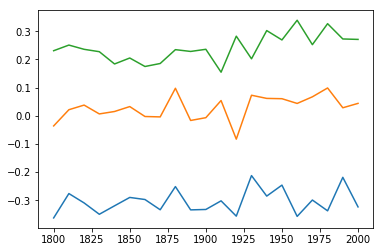

In [33]:
target_art = ["poetry", "art", "Shakespeare", "dance", "literature", "novel", "symphony", "drama"]
target_math = ["math", "algebra", "geometry", "calculus", "equations", "computation", "numbers", "Newton"]
target_science = ["science", "technology", "physics", "chemistry", "Einstein", "NASA", "experiment", "astronomy"]

target_domestic = ["house", "home", "clean", "sew", "children", "cook", "garden", "laundry"]
target_intellectual = ["college", "learn", "book", "write", "study", "art", "science", "math"]

attr_fem = ["sister", "mother", "aunt", "grandmother", "daughter", "she", "hers", "her"]
attr_masc = ["brother", "father", "uncle", "grandfather", "son", "he", "his", "him"]

weat_art_math = np.zeros(len(decades))
weat_art_science = np.zeros(len(decades))
weat_dom_int =  np.zeros(len(decades))

for i, decade in enumerate(decades):
    weat_art_math[i] = weat(target_art, target_math, attr_fem, attr_masc, embeddings[decade])
    weat_art_science[i] = weat(target_art, target_science, attr_fem, attr_masc, embeddings[decade])
    weat_dom_int[i] = weat(target_domestic, target_intellectual, attr_fem, attr_masc, embeddings[decade])
    
plt.plot(decades,weat_art_math)
plt.plot(decades,weat_art_science)
plt.plot(decades,weat_dom_int)
plt.show()